In [3]:
import os
import pandas as pd

# DataFrame 초기화
df = pd.DataFrame(columns=['user_ID', 'trial_ID', 'task_ID', 'gx', 'gy', 'gz', 'ax', 'ay', 'az', 'label'])

# task_id와 매핑되는 label 정보 생성
label_mapping = {
    'D01': 'walking',
    'D02': 'walking',
    'D03': 'jogging',
    'D04': 'jogging',
    'D05': 'stairs_walking',
    'D06': 'stairs_walking',
    'D09': 'standing',
    'D15': 'standing',
    'D12': 'lying',
    'D13': 'lying',
    'F01': 'fall',
    'F02': 'fall',
    'F06': 'fall',
    'F05': 'fall',
    'F03': 'fall',
    'F12': 'fall'
}

# 데이터 폴더 경로
data_folder = '../data/SisFall_dataset'

# 폴더 내의 파일들을 확인하고 처리
record_count = 0  # 전체 파일에서의 레코드 개수
for root, dirs, files in os.walk(data_folder):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        user_ID = dir_name

        # user_ID가 'SA' 또는 'SE'로 시작하고 뒤에 오는 숫자가 7이거나 8인 경우 건너뛰기
        if user_ID.startswith('SA') or user_ID.startswith('SE'):
            numeric_part = user_ID[2:]
            if user_ID.startswith('SA') or user_ID.startswith('SE'):
                numeric_part = user_ID[2:]
                if numeric_part.isdigit() and int(numeric_part)%10 >= 6 and int(numeric_part)%10 <= 9:
                    continue


        for file_name in os.listdir(dir_path):
            if file_name.endswith('.txt'):
                # 파일 경로
                file_path = os.path.join(dir_path, file_name)

                # 파일 이름에 대한 정보
                activity, _, trial_ID_with_extension = file_name.split('_')
                trial_ID = trial_ID_with_extension[:-4]  # .txt 제거

                if activity in ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D09', 'D12', 'D13', 'D15', 'F01', 'F02', 'F03', 'F05', 'F06', 'F12']:
                    # task_id에 해당하는 label 정보
                    task_ID = activity
                    label = label_mapping[task_ID]

                    #Angular velocity 변환을 위한 공식에 사용되는 값들
                    Range = 2000  # 예시 값을 사용
                    Resolution = 16  # 예시 값을 사용

                    range_g = 16  # range for ADXL345 when set to ±16g
                    resolution_bits = 13  # resolution for ADXL345

                    # 파일에서 데이터를 읽어와서 처리
                    with open(file_path, 'r', encoding='utf-8') as file:
                        lines = file.readlines()

                    # 데이터 파싱 및 계산
                    gx_values = []
                    gy_values = []
                    gz_values = []

                    ax_values = []
                    ay_values = []
                    az_values = []

                    # 데이터 파싱 및 DataFrame에 추가
                    for i, line in enumerate(lines):
                        if i % 20 == 0:  # 20의 배수인 행만 처리
                            # 쉼표를 기준으로 줄을 분리하여 필드의 값을 가져오기
                            fields = line.strip().split(',')

                            if len(fields) >= 6:  # 필드 수 확인
                                # gx, gy, gz 값 얻기 및 변환 계산
                                gx_value = (2 * Range / (2 ** Resolution)) * float(fields[3])
                                gy_value = (2 * Range / (2 ** Resolution)) * float(fields[4])
                                gz_value = (2 * Range / (2 ** Resolution)) * float(fields[5])

                                ax_value = (2 * range_g / (2 ** resolution_bits)) * float(fields[0])
                                ay_value = (2 * range_g / (2 ** resolution_bits)) * float(fields[1])
                                az_value = (2 * range_g / (2 ** resolution_bits)) * float(fields[2])


                                gx_values.append(gx_value)
                                gy_values.append(gy_value)
                                gz_values.append(gz_value)

                                ax_values.append(ax_value)
                                ay_values.append(ay_value)
                                az_values.append(az_value)

                                if len(gx_values) == 1:
                                    # 한 줄의 레코드 처리가 완료되었으므로 DataFrame에 추가
                                    df.loc[len(df)] = {
                                        'user_ID': user_ID,
                                        'trial_ID': trial_ID,
                                        'task_ID': task_ID,
                                        'gx': gx_values[0],
                                        'gy': gy_values[0],
                                        'gz': gz_values[0],
                                        'ax': ax_values[0],
                                        'ay': ay_values[0],
                                        'az': az_values[0],
                                        'label': label
                                    }
                                    record_count += 1

                                    gx_values = []
                                    gy_values = []
                                    gz_values = []

                                    ax_values = []
                                    ay_values = []
                                    az_values = []


print(df)

from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 인스턴스 생성
scaler = MinMaxScaler(feature_range=(-1, 1))

# 'gx', 'gy', 'gz' 열의 데이터 추출
data = df[['gx', 'gy', 'gz','ax', 'ay', 'az']].values

# 데이터 스케일링
scaled_data = scaler.fit_transform(data)

# 스케일링된 값을 새로운 열에 저장
df['scaled_gx'] = scaled_data[:, 0]
df['scaled_gy'] = scaled_data[:, 1]
df['scaled_gz'] = scaled_data[:, 2]
df['scaled_ax'] = scaled_data[:, 3]
df['scaled_ay'] = scaled_data[:, 4]
df['scaled_az'] = scaled_data[:, 5]

print(df.head())

# CSV 파일로 저장
csv_path = '../data/SisFall_train_L_20_0619.csv'
df.to_csv(csv_path, index=False)
print('CSV 파일이 저장되었습니다:', csv_path)

       user_ID trial_ID task_ID         gx         gy         gz        ax   
0         SA01      R01     D01  -1.098633 -30.761719 -21.484375  0.066406  \
1         SA01      R01     D01  31.860352 -22.216797   8.056641  0.335938   
2         SA01      R01     D01   7.263184  15.869141  26.184082  0.046875   
3         SA01      R01     D01 -14.526367  31.005859  11.474609  0.019531   
4         SA01      R01     D01 -12.512207  39.550781  -4.943848  0.042969   
...        ...      ...     ...        ...        ...        ...       ...   
232357    SE15      R05     D08  -1.220703   4.638672   0.488281 -0.031250   
232358    SE15      R05     D08  -1.281738   5.737305   0.427246 -0.050781   
232359    SE15      R05     D08  -1.647949   5.126953   0.488281 -0.031250   
232360    SE15      R05     D08  -1.098633   5.676270   0.366211 -0.019531   
232361    SE15      R05     D08  -1.403809   5.371094   0.305176 -0.023438   

              ay        az             label  
0      -0.699219

In [4]:
print(df['user_ID'].unique())

['SA01' 'SA02' 'SA03' 'SA04' 'SA05' 'SA10' 'SA11' 'SA12' 'SA13' 'SA14'
 'SA15' 'SA20' 'SA21' 'SA22' 'SA23' 'SE01' 'SE02' 'SE03' 'SE04' 'SE05'
 'SE10' 'SE11' 'SE12' 'SE13' 'SE14' 'SE15']


In [5]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# DataFrame 초기화
df_val = pd.DataFrame(columns=['user_ID', 'trial_ID', 'task_ID', 'gx', 'gy', 'gz', 'ax', 'ay', 'az', 'label'])

# task_id와 매핑되는 label 정보 생성
label_mapping = {
    'D01': 'walking',
    'D02': 'walking',
    'D03': 'jogging',
    'D04': 'jogging',
    'D05': 'stairs_walking',
    'D06': 'stairs_walking',
    'D09': 'standing',
    'D15': 'standing',
    'D12': 'lying',
    'D13': 'lying',
    'F01': 'fall',
    'F02': 'fall',
    'F06': 'fall',
    'F05': 'fall',
    'F03': 'fall',
    'F12': 'fall'
}

# 데이터 폴더 경로
data_folder = '../data/SisFall_dataset'

# 폴더 내의 파일들을 확인하고 처리
record_count = 0  # 전체 파일에서의 레코드 개수
for root, dirs, files in os.walk(data_folder):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        user_ID = dir_name

        # user_ID가 'SA' 또는 'SE'로 시작하고 뒤에 오는 숫자가 7이나 8인 경우 처리
        if user_ID.startswith('SA') or user_ID.startswith('SE'):
            numeric_part = user_ID[2:]
            if numeric_part.isdigit() and int(numeric_part) in [7, 8]:
                for file_name in os.listdir(dir_path):
                    if file_name.endswith('.txt'):
                        # 파일 경로
                        file_path = os.path.join(dir_path, file_name)

                        # 파일 이름에 대한 정보
                        activity, _, trial_ID_with_extension = file_name.split('_')
                        trial_ID = trial_ID_with_extension[:-4]  # .txt 제거

                        if activity in  ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D09', 'D12', 'D13', 'D15', 'F01', 'F02', 'F03', 'F05', 'F06', 'F12']:
                            # task_id에 해당하는 label 정보
                            task_ID = activity
                            label = label_mapping[task_ID]

                            # Angular velocity 변환을 위한 공식에 사용되는 값들
                            Range = 2000  # 예시 값을 사용
                            Resolution = 16  # 예시 값을 사용

                            range_g = 16  # range for ADXL345 when set to ±16g
                            resolution_bits = 13  # resolution for ADXL345

                            # 파일에서 데이터를 읽어와서 처리
                            with open(file_path, 'r', encoding='utf-8') as file:
                                lines = file.readlines()

                            # 데이터 파싱 및 계산
                            gx_values = []
                            gy_values = []
                            gz_values = []

                            ax_values = []
                            ay_values = []
                            az_values = []

                            # 데이터 파싱 및 DataFrame에 추가
                            for i, line in enumerate(lines):
                                if i % 20 == 0:  # 10의 배수인 행만 처리
                                    # 쉼표를 기준으로 줄을 분리하여 필드의 값을 가져오기
                                    fields = line.strip().split(',')

                                    if len(fields) >= 6:  # 필드 수 확인
                                        # gx, gy, gz 값 얻기 및 변환 계산
                                        gx_value = (2 * Range / (2 ** Resolution)) * float(fields[3])
                                        gy_value = (2 * Range / (2 ** Resolution)) * float(fields[4])
                                        gz_value = (2 * Range / (2 ** Resolution)) * float(fields[5])

                                        ax_value = (2 * range_g / (2 ** resolution_bits)) * float(fields[0])
                                        ay_value = (2 * range_g / (2 ** resolution_bits)) * float(fields[1])
                                        az_value = (2 * range_g / (2 ** resolution_bits)) * float(fields[2])

                                        gx_values.append(gx_value)
                                        gy_values.append(gy_value)
                                        gz_values.append(gz_value)

                                        ax_values.append(ax_value)
                                        ay_values.append(ay_value)
                                        az_values.append(az_value)

                                        if len(gx_values) == 1:
                                            # 한 줄의 레코드 처리가 완료되었으므로 DataFrame에 추가
                                            df_val.loc[len(df_val)] = {
                                                'user_ID': user_ID,
                                                'trial_ID': trial_ID,
                                                'task_ID': task_ID,
                                                'gx': gx_values[0],
                                                'gy': gy_values[0],
                                                'gz': gz_values[0],
                                                'ax': ax_values[0],
                                                'ay': ay_values[0],
                                                'az': az_values[0],
                                                'label': label
                                            }
                                            record_count += 1

                                            gx_values = []
                                            gy_values = []
                                            gz_values = []

                                            ax_values = []
                                            ay_values = []
                                            az_values = []

# MinMaxScaler 인스턴스 생성
scaler = MinMaxScaler(feature_range=(-1, 1))

# 'gx', 'gy', 'gz', 'ax', 'ay', 'az' 열의 데이터 추출
data = df_val[['gx', 'gy', 'gz', 'ax', 'ay', 'az']].values

# 데이터 스케일링
scaled_data = scaler.fit_transform(data)

# 스케일링된 값을 새로운 열에 저장
df_val['scaled_gx'] = scaled_data[:, 0]
df_val['scaled_gy'] = scaled_data[:, 1]
df_val['scaled_gz'] = scaled_data[:, 2]
df_val['scaled_ax'] = scaled_data[:, 3]
df_val['scaled_ay'] = scaled_data[:, 4]
df_val['scaled_az'] = scaled_data[:, 5]

# CSV 파일로 저장
csv_path = '../data/SisFall_val_L_20_0619.csv'
df_val.to_csv(csv_path, index=False)
print('CSV 파일이 저장되었습니다:', csv_path)

CSV 파일이 저장되었습니다: ../data/SisFall_val_L_20.csv


In [6]:
print(df_val['user_ID'].unique())

['SA07' 'SA08' 'SE07' 'SE08']


In [7]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# DataFrame 초기화
df_test = pd.DataFrame(columns=['user_ID', 'trial_ID', 'task_ID', 'gx', 'gy', 'gz', 'ax', 'ay', 'az', 'label'])

# task_id와 매핑되는 label 정보 생성
label_mapping = {
    'D01': 'walking',
    'D02': 'walking',
    'D03': 'jogging',
    'D04': 'jogging',
    'D05': 'stairs_walking',
    'D06': 'stairs_walking',
    'D09': 'standing',
    'D15': 'standing',
    'D12': 'lying',
    'D13': 'lying',
    'F01': 'fall',
    'F02': 'fall',
    'F06': 'fall',
    'F05': 'fall',
    'F03': 'fall',
    'F12': 'fall'
}

# 데이터 폴더 경로
data_folder = '../data/SisFall_dataset'

# 폴더 내의 파일들을 확인하고 처리
record_count = 0  # 전체 파일에서의 레코드 개수
for root, dirs, files in os.walk(data_folder):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        user_ID = dir_name

        # user_ID가 'SA' 또는 'SE'로 시작하고 뒤에 오는 숫자가 7이나 8인 경우 처리
        if user_ID.startswith('SA') or user_ID.startswith('SE'):
            numeric_part = user_ID[2:]
            if numeric_part.isdigit() and int(numeric_part) in [6, 9]:
                for file_name in os.listdir(dir_path):
                    if file_name.endswith('.txt'):
                        # 파일 경로
                        file_path = os.path.join(dir_path, file_name)

                        # 파일 이름에 대한 정보
                        activity, _, trial_ID_with_extension = file_name.split('_')
                        trial_ID = trial_ID_with_extension[:-4]  # .txt 제거

                        if activity in  ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D09', 'D12', 'D13', 'D15', 'F01', 'F02', 'F03', 'F05', 'F06', 'F12']:
                            # task_id에 해당하는 label 정보
                            task_ID = activity
                            label = label_mapping[task_ID]

                            # Angular velocity 변환을 위한 공식에 사용되는 값들
                            Range = 2000  # 예시 값을 사용
                            Resolution = 16  # 예시 값을 사용

                            range_g = 16  # range for ADXL345 when set to ±16g
                            resolution_bits = 13  # resolution for ADXL345

                            # 파일에서 데이터를 읽어와서 처리
                            with open(file_path, 'r', encoding='utf-8') as file:
                                lines = file.readlines()

                            # 데이터 파싱 및 계산
                            gx_values = []
                            gy_values = []
                            gz_values = []

                            ax_values = []
                            ay_values = []
                            az_values = []

                            # 데이터 파싱 및 DataFrame에 추가
                            for i, line in enumerate(lines):
                                if i % 20 == 0:  # 10의 배수인 행만 처리
                                    # 쉼표를 기준으로 줄을 분리하여 필드의 값을 가져오기
                                    fields = line.strip().split(',')

                                    if len(fields) >= 6:  # 필드 수 확인
                                        # gx, gy, gz 값 얻기 및 변환 계산
                                        gx_value = (2 * Range / (2 ** Resolution)) * float(fields[3])
                                        gy_value = (2 * Range / (2 ** Resolution)) * float(fields[4])
                                        gz_value = (2 * Range / (2 ** Resolution)) * float(fields[5])

                                        ax_value = (2 * range_g / (2 ** resolution_bits)) * float(fields[0])
                                        ay_value = (2 * range_g / (2 ** resolution_bits)) * float(fields[1])
                                        az_value = (2 * range_g / (2 ** resolution_bits)) * float(fields[2])

                                        gx_values.append(gx_value)
                                        gy_values.append(gy_value)
                                        gz_values.append(gz_value)

                                        ax_values.append(ax_value)
                                        ay_values.append(ay_value)
                                        az_values.append(az_value)

                                        if len(gx_values) == 1:
                                            # 한 줄의 레코드 처리가 완료되었으므로 DataFrame에 추가
                                            df_test.loc[len(df_test)] = {
                                                'user_ID': user_ID,
                                                'trial_ID': trial_ID,
                                                'task_ID': task_ID,
                                                'gx': gx_values[0],
                                                'gy': gy_values[0],
                                                'gz': gz_values[0],
                                                'ax': ax_values[0],
                                                'ay': ay_values[0],
                                                'az': az_values[0],
                                                'label': label
                                            }
                                            record_count += 1

                                            gx_values = []
                                            gy_values = []
                                            gz_values = []

                                            ax_values = []
                                            ay_values = []
                                            az_values = []

# MinMaxScaler 인스턴스 생성
scaler = MinMaxScaler(feature_range=(-1, 1))

# 'gx', 'gy', 'gz', 'ax', 'ay', 'az' 열의 데이터 추출
data = df_test[['gx', 'gy', 'gz', 'ax', 'ay', 'az']].values

# 데이터 스케일링
scaled_data = scaler.fit_transform(data)

# 스케일링된 값을 새로운 열에 저장
df_test['scaled_gx'] = scaled_data[:, 0]
df_test['scaled_gy'] = scaled_data[:, 1]
df_test['scaled_gz'] = scaled_data[:, 2]
df_test['scaled_ax'] = scaled_data[:, 3]
df_test['scaled_ay'] = scaled_data[:, 4]
df_test['scaled_az'] = scaled_data[:, 5]

# CSV 파일로 저장
csv_path = '../data/SisFall_test_L_20_0619.csv'
df_test.to_csv(csv_path, index=False)
print('CSV 파일이 저장되었습니다:', csv_path)

CSV 파일이 저장되었습니다: ../data/SisFall_test_L_20_0619.csv


In [8]:
print(df_test['user_ID'].unique())

['SA06' 'SA09' 'SE06' 'SE09']


In [2]:
from keras.optimizers import SGD
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import f1_score

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20_0619.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20_0619.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(6, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.02), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=450, batch_size=32, validation_data=(X_test, y_test))

# 최상의 적합 모델의 가중치를 피클 파일로 저장
best_model_weights = model.get_weights()
pickle.dump(best_model_weights, open('../model/best_model_weights_cnn_lstm_g_SGD.pkl', 'wb'))

# 레이블 인코더의 클래스 정보를 저장
np.save('../model/label_encoder_classes_cnn_lstm_g_SGD.npy', label_encoder.classes_)

# 모델 저장
model.save('../model/loaded_model_cnn_lstm_g_SGD.h5')

# bestfit 프린트
bestfit = np.argmax(history.history['val_accuracy'])
print("Best Fit:", bestfit)

# F1 스코어 계산
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')
print("F1 score:", f1)

Epoch 1/450
431/431 [==============================] - 5s 7ms/step - loss: 0.5184 - accuracy: 0.4006 - val_loss: 0.4186 - val_accuracy: 0.4478
Epoch 2/450
431/431 [==============================] - 2s 5ms/step - loss: 0.3930 - accuracy: 0.4393 - val_loss: 0.3608 - val_accuracy: 0.4796
Epoch 3/450
431/431 [==============================] - 2s 5ms/step - loss: 0.3609 - accuracy: 0.4644 - val_loss: 0.3402 - val_accuracy: 0.5002
Epoch 4/450
431/431 [==============================] - 2s 5ms/step - loss: 0.3445 - accuracy: 0.4824 - val_loss: 0.3260 - val_accuracy: 0.5105
Epoch 5/450
431/431 [==============================] - 2s 5ms/step - loss: 0.3326 - accuracy: 0.4951 - val_loss: 0.3126 - val_accuracy: 0.5287
Epoch 6/450
431/431 [==============================] - 2s 5ms/step - loss: 0.3213 - accuracy: 0.5111 - val_loss: 0.3029 - val_accuracy: 0.5449
Epoch 7/450
431/431 [==============================] - 2s 5ms/step - loss: 0.3125 - accuracy: 0.5305 - val_loss: 0.2939 - val_accuracy: 0.5606

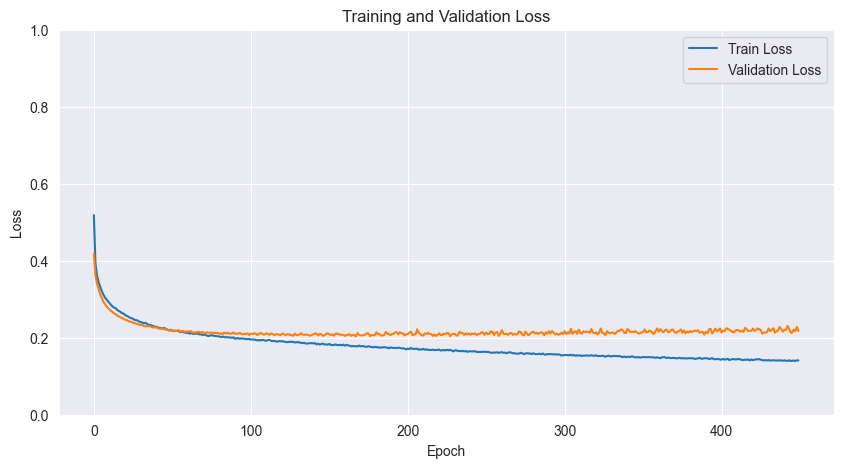

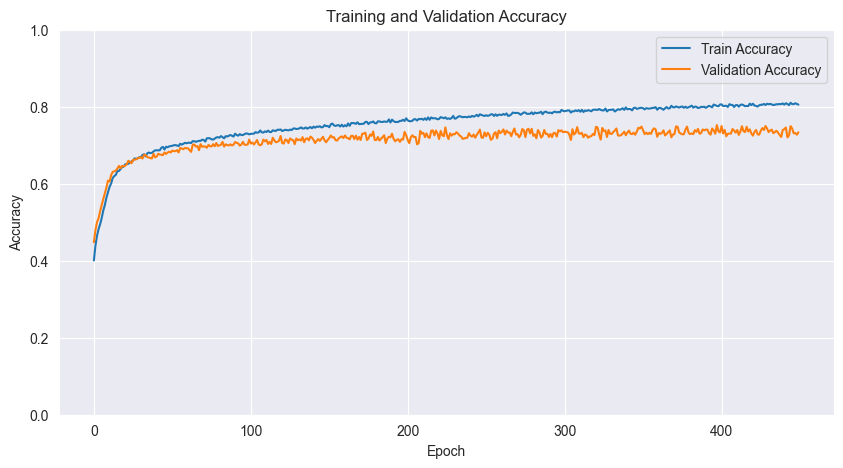

In [3]:
import matplotlib.pyplot as plt

# Get the training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim([0, 1])
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [4]:
from sklearn.metrics import confusion_matrix

# 예측 결과 디코딩
y_pred_encoded = np.argmax(y_pred, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)

# 실제 레이블 디코딩
y_test_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

# 컨퓨전 메트릭스 계산
confusion_mat = confusion_matrix(y_test_labels, y_pred_labels)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[387  10   1  26   9  17]
 [  6 387   0   5   0   1]
 [ 64   0  95  11   9   0]
 [127  12   5 203   4  23]
 [ 99   0   6  13 120   0]
 [ 79   3   0  13   0 304]]


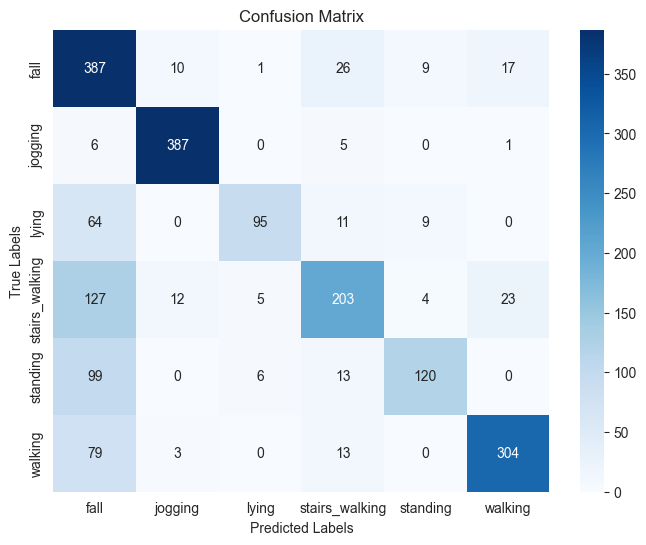

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 예측 결과 디코딩
y_pred_encoded = np.argmax(y_pred, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)

# 실제 레이블 디코딩
y_test_labels = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

# 컨퓨전 메트릭스 계산
confusion_mat = confusion_matrix(y_test_labels, y_pred_labels)

# 클래스 이름 설정
class_names = label_encoder.classes_

# 컨퓨전 메트릭스를 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [9]:
# 다른 데이터로 테스트
# 데이터 준비
new_data = pd.read_csv('../data/SisFall_test_L_20_0619.csv')

# 입력 데이터 생성
X_new = []
for i in range(0, len(new_data) - 19, 20):
    gx_values = new_data.loc[i:i+19, 'gx'].values
    gy_values = new_data.loc[i:i+19, 'gy'].values
    gz_values = new_data.loc[i:i+19, 'gz'].values
    X_new.append(np.transpose([gx_values, gy_values, gz_values]))
X_new = np.array(X_new)

# 예측
y_pred = model.predict(X_new)

# 예측 결과 디코딩
y_pred_encoded = np.argmax(y_pred, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)

# 예측 결과 출력
print(y_pred_labels)

# 정확도 계산
_, accuracy = model.evaluate(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

74/74 [==============================] - 0s 2ms/step
['stairs_walking' 'walking' 'walking' ... 'fall' 'standing' 'fall']
64/64 [==============================] - 0s 1ms/step - loss: 0.2174 - accuracy: 0.7337
Accuracy: 73.37%


In [12]:
from keras.optimizers import Adam
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import f1_score

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20_0619.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20_0619.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(6, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/200
431/431 [==============================] - 4s 6ms/step - loss: 0.2998 - accuracy: 0.5767 - val_loss: 0.2340 - val_accuracy: 0.6596
Epoch 2/200
431/431 [==============================] - 2s 5ms/step - loss: 0.2305 - accuracy: 0.6733 - val_loss: 0.2226 - val_accuracy: 0.6734
Epoch 3/200
431/431 [==============================] - 2s 5ms/step - loss: 0.2164 - accuracy: 0.6987 - val_loss: 0.2161 - val_accuracy: 0.7013
Epoch 4/200
431/431 [==============================] - 2s 5ms/step - loss: 0.2042 - accuracy: 0.7154 - val_loss: 0.2176 - val_accuracy: 0.6964
Epoch 5/200
431/431 [==============================] - 2s 5ms/step - loss: 0.1979 - accuracy: 0.7248 - val_loss: 0.2174 - val_accuracy: 0.6999
Epoch 6/200
431/431 [==============================] - 2s 5ms/step - loss: 0.1906 - accuracy: 0.7361 - val_loss: 0.2164 - val_accuracy: 0.7028
Epoch 7/200
431/431 [==============================] - 2s 5ms/step - loss: 0.1840 - accuracy: 0.7460 - val_loss: 0.2149 - val_accuracy: 0.7077

In [13]:
from keras.optimizers import SGD
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import f1_score

# 데이터셋 준비
train_df = pd.read_csv('../data/SisFall_train_L_20_0619.csv')  # 훈련 파일
test_df = pd.read_csv('../data/SisFall_val_L_20_0619.csv')  # 테스트 파일

X_train = []  # 훈련 입력 데이터
y_train = []  # 훈련 출력 데이터

X_test = []  # 테스트 입력 데이터
y_test = []  # 테스트 출력 데이터

# 4개의 레코드씩 묶어서 처리
for i in range(0, len(train_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = train_df.loc[i:i+19, 'gx'].values
    gy_values = train_df.loc[i:i+19, 'gy'].values
    gz_values = train_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = train_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_train.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_train.append(labels[0])

for i in range(0, len(test_df) - 19, 20):
    # gx, gy, gz 값 가져오기
    gx_values = test_df.loc[i:i+19, 'gx'].values
    gy_values = test_df.loc[i:i+19, 'gy'].values
    gz_values = test_df.loc[i:i+19, 'gz'].values

    # 레이블 값 가져오기
    labels = test_df.loc[i:i+19, 'label'].values

    # 서로 다른 레이블이 포함된 경우 해당 시퀀스는 분석에서 제외
    if len(set(labels)) == 1:
        # 시퀀스로 변환하여 입력 데이터에 추가
        X_test.append(np.transpose([gx_values, gy_values, gz_values]))

        # 레이블 값 중복 제거하여 출력 데이터에 추가
        y_test.append(labels[0])

# 입력 데이터와 출력 데이터를 넘파이 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# 출력 데이터를 One-Hot 인코딩
label_encoder = LabelEncoder()
integer_encoded_train = label_encoder.fit_transform(y_train)
integer_encoded_train = integer_encoded_train.reshape(len(integer_encoded_train), 1)
onehot_encoder_train = OneHotEncoder(sparse_output=False)
y_train = onehot_encoder_train.fit_transform(integer_encoded_train)

integer_encoded_test = label_encoder.transform(y_test)
integer_encoded_test = integer_encoded_test.reshape(len(integer_encoded_test), 1)
onehot_encoder_test = OneHotEncoder(sparse_output=False)
y_test = onehot_encoder_test.fit_transform(integer_encoded_test)

# CNN-LSTM 모델 정의
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(20, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout layer with 20% dropout rate
model.add(BatchNormalization())  # Batch normalization layer
model.add(LSTM(128))
model.add(Dense(6, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
431/431 [==============================] - 6s 8ms/step - loss: 1.4178 - accuracy: 0.4259 - val_loss: 1.2542 - val_accuracy: 0.4963
Epoch 2/100
431/431 [==============================] - 3s 6ms/step - loss: 1.2077 - accuracy: 0.5158 - val_loss: 1.0877 - val_accuracy: 0.5763
Epoch 3/100
431/431 [==============================] - 3s 6ms/step - loss: 1.0879 - accuracy: 0.5760 - val_loss: 0.9905 - val_accuracy: 0.6175
Epoch 4/100
431/431 [==============================] - 3s 7ms/step - loss: 1.0096 - accuracy: 0.6111 - val_loss: 0.9360 - val_accuracy: 0.6371
Epoch 5/100
431/431 [==============================] - 3s 7ms/step - loss: 0.9581 - accuracy: 0.6309 - val_loss: 0.8973 - val_accuracy: 0.6484
Epoch 6/100
431/431 [==============================] - 3s 6ms/step - loss: 0.9220 - accuracy: 0.6421 - val_loss: 0.8775 - val_accuracy: 0.6547
Epoch 7/100
431/431 [==============================] - 3s 6ms/step - loss: 0.8963 - accuracy: 0.6468 - val_loss: 0.8630 - val_accuracy: 0.6572